# Deep Reinforcement Lerning Lectures - Policy Gradients

### Imports and auxiliary settings

In [1]:
!apt update
!apt install -y xvfb x11-utils python3-opengl ffmpeg swig
!pip install swig
!pip install numpy==1.26.4
!pip install jax==0.4.13 jaxlib==0.4.13
!pip install gymnasium==0.27.1 gymnasium[box2d] pyvirtualdisplay imageio-ffmpeg moviepy==1.0.3
!pip install onnx onnx2pytorch==0.4.1


Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,676 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [4,363 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,939 kB]
Get:13 http://archive.ubuntu.com

In [1]:
# select device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
%matplotlib inline

# PyTorch imports
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.utils.data import Dataset, DataLoader

# Cross Framework library for DL
import onnx
from onnx2pytorch import ConvertModel

# Auxiliary Python imports
import os
import math
import io
import base64
import random
import shutil
import copy
import glob
from time import time, strftime
from tqdm import tqdm
import numpy as np
from tqdm.notebook import tqdm
from time import sleep

# Environment import and set logger level to display error only
# Environment import and set logger level to display error only
import gymnasium as gym
from gymnasium.spaces import Box
from gymnasium import logger as gymlogger
from gymnasium.wrappers import RecordVideo
gymlogger.set_level(gym.logger.ERROR)

# Plotting and notebook imports
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from IPython.display import HTML, display, clear_output

# start virtual display
from pyvirtualdisplay import Display
pydisplay = Display(visible=0, size=(640, 480))
pydisplay.start()

ERROR:jax._src.xla_bridge:Jax plugin configuration error: Plugin module %s could not be loaded
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/xla_bridge.py", line 420, in discover_pjrt_plugins
    plugin_module = importlib.import_module(plugin_module_name)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_r

In [3]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Auxiliary Methods

In [4]:
class Logger(object):
    """Logger that can be used for debugging different values
    """
    def __init__(self, logdir, params=None, debug=False):
        self.gradients = []
        self.debug = debug
        self.basepath = os.path.join(logdir, strftime("%Y-%m-%dT%H-%M-%S"))
        os.makedirs(self.basepath, exist_ok=True)
        os.makedirs(self.log_dir, exist_ok=True)
        if params is not None and os.path.exists(params):
            shutil.copyfile(params, os.path.join(self.basepath, "params.pkl"))
        self.log_dict = {}
        self.dump_idx = {}

    def add_gradients(self, grad):
        if not self.debug: return
        self.gradients.append(grad)

    def compute_gradient_variance(self):
        vars_ = []
        grads_list = [np.zeros_like(self.gradients[0])] * 100
        for i, grads in enumerate(self.gradients):
            grads_list.append(grads)
            grads_list = grads_list[1:]
            grad_arr = np.stack(grads_list, axis=0)
            g = np.apply_along_axis(grad_variance, axis=-1, arr=grad_arr)
            vars_.append(np.mean(g))
        return vars_

    @property
    def param_file(self):
        return os.path.join(self.basepath, "params.pkl")

    @property
    def onnx_file(self):
        return os.path.join(self.basepath, "model.onnx")

    @property
    def video_dir(self):
        return os.path.join(self.basepath, "videos")

    @property
    def log_dir(self):
        return os.path.join(self.basepath, "logs")

    def log(self, name, value):
        if name not in self.log_dict:
            self.log_dict[name] = []
            self.dump_idx[name] = -1
        self.log_dict[name].append((len(self.log_dict[name]), time(), value))

    def get_values(self, name):
        if name in self.log_dict:
            return [x[2] for x in self.log_dict[name]]
        return None

    def dump(self):
        for name, rows in self.log_dict.items():
            with open(os.path.join(self.log_dir, name + ".log"), "a") as f:
                for i, row in enumerate(rows):
                    if i > self.dump_idx[name]:
                        f.write(",".join([str(x) for x in row]) + "\n")
                        self.dump_idx[name] = i

In [5]:
def wrap_env(env, logger, capture_video=True):
    # wrapper for recording
    env = gym.wrappers.RecordEpisodeStatistics(env)
    if capture_video:
        env = gym.wrappers.RecordVideo(env, logger.video_dir, episode_trigger=lambda idx: True)
    return env


def create_env(logger, env_id='BipedalWalker-v3', hardcore=False, capture_video=True):
    # initialize environment
    #env = wrap_env(gym.make(env_id, max_episode_steps=400, hardcore=hardcore, render_mode="rgb_array"),
    env = wrap_env(gym.make(env_id, hardcore=hardcore, render_mode="rgb_array"),
                   logger=logger,
                   capture_video=capture_video)
    action_size = env.action_space.shape[0]
    state_size = env.observation_space.shape[0]
    return env, action_size, state_size


def set_seed(env, seed=None):
    # seeding the envrionment
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)


def transforms(state):
    # transofrm to numpy to tensor and push to device
    return torch.FloatTensor(state).to(device)


def test_environment(env, agent=None, seed=42, n_steps=200):
    # run and evaluate in the environment
    state, info = env.reset(seed=seed)
    for i in range(n_steps):
        env.render()

        if agent is None:
            action = env.action_space.sample()
        else:
            action, _ = agent.act(state)
            action = action.squeeze().cpu().numpy()
        state, reward, done, truncated, info = env.step(action)
        if done:
            state, info = env.reset(seed=seed)
    env.close()


def get_running_stat(stat, stat_len):
    # evaluate stats
    cum_sum = np.cumsum(np.insert(stat, 0, 0))
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len


def plot_results(runner):
    # plot stats
    episode, r, l = np.array(runner.stats_rewards_list).T
    cum_r = get_running_stat(r, 10)
    cum_l = get_running_stat(l, 10)

    plt.figure(figsize=(16, 16))

    plt.subplot(321)

    # plot rewards
    plt.plot(episode[-len(cum_r):], cum_r)
    plt.plot(episode, r, alpha=0.5)
    plt.xlabel('Episode')
    plt.ylabel('Episode Reward')

    plt.subplot(322)

    # plot episode lengths
    plt.plot(episode[-len(cum_l):], cum_l)
    plt.plot(episode, l, alpha=0.5)
    plt.xlabel('Episode')
    plt.ylabel('Episode Length')

    plt.subplot(323)

    # plot return
    all_returns = np.array(runner.buffer.all_returns)
    plt.scatter(range(0, len(all_returns)), all_returns, alpha=0.5)
    mean_returns = np.array(runner.buffer.mean_returns)
    plt.plot(range(0, len(mean_returns)), mean_returns, color="orange")
    plt.xlabel('Episode')
    plt.ylabel('Return')

    plt.subplot(324)

    # plot entropy
    entropy_arr = np.array(runner.stats_entropy_list)
    plt.plot(range(0, len(entropy_arr)), entropy_arr)
    plt.xlabel('Episode')
    plt.ylabel('Entropy')

    plt.subplot(325)

    if runner.logger.debug:
        # plot variance
        variance_arr = np.array(runner.logger.compute_gradient_variance())
        plt.plot(range(0, len(variance_arr)), variance_arr)
        plt.xlabel('Episode')
        plt.ylabel('Variance')

    plt.show()


"""
Utility functions to enable video recording of gym environment and displaying it
"""
def show_video(logger):
    print(logger.video_dir)
    mp4list = glob.glob(f'{logger.video_dir}/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                  loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def grad_variance(g):
    # compute gradient variance
    return np.mean(g**2) - np.mean(g)**2

### Test environment

OpenAI offers a set of environments for Reinforcement Learning, which are accessible via the `gymnasium` pip package.
In this exercise we will focus on discrete control tasks using a Box2D simulation known as BipedalWalker-v3.
To access the Box2D packages, we use the gymnasium pypi `box2d` option.

In [6]:
# show behavior in envrionment with random agent
logger = Logger("logdir")
env, _, _ = create_env(logger)
test_environment(env)
show_video(logger)

Moviepy - Building video /content/logdir/2025-05-16T05-13-27/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/logdir/2025-05-16T05-13-27/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logdir/2025-05-16T05-13-27/videos/rl-video-episode-0.mp4
logdir/2025-05-16T05-13-27/videos


### Training Buffer

In [7]:
class Transition(object):
    """Transition helper object
    """
    def __init__(self, state, action, reward, next_state, log_probs, done, value=0.0, advantage=0.0, g_return=0.0):
        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = next_state
        self.g_return = 0.0
        self.log_probs = log_probs
        self.done = done
        self.value = value
        self.advantage = advantage
        self.g_return = g_return


class Episode(object):
    """Class for collecting an episode of transitions
    """
    def __init__(self, discount):
        self.discount = discount
        self._empty()
        self.total_reward = 0.0

    def _empty(self):
        self.n = 0
        self.transitions = []

    def reset(self):
        self._empty()

    def size(self):
        return self.n

    def append(self, transition):
        self.transitions.append(transition)
        self.n += 1

    def states(self):
        return [s.state for s in self.transitions]

    def actions(self):
        return [a.action for a in self.transitions]

    def rewards(self):
        return [r.reward for r in self.transitions]

    def next_states(self):
        return [s_.next_state for s_ in self.transitions]

    def returns(self):
        return [r.g_return for r in self.transitions]

    def calculate_return(self):
        # calculate the return of the episode
        rewards = self.rewards()
        trajectory_len = len(rewards)
        return_array = torch.zeros((trajectory_len,))
        g_return = 0.
        for i in range(trajectory_len-1, -1, -1):
            g_return = rewards[i] + self.discount*g_return
            g_val = g_return.item() if torch.is_tensor(g_return) else g_return  # CPU float
            return_array[i] = g_val
            self.transitions[i].g_return = g_val
        return return_array

    def compute_gae(self, lam=0.95):
        # 把 V(s) 取出来并补一个 V_{T+1}=0
        values = [t.value for t in self.transitions] + [0.0]
        gae = 0.0
        for i in reversed(range(self.n)):
            delta = (
                self.transitions[i].reward
                + self.discount * values[i+1] * (1 - self.transitions[i].done)
                - values[i]
            )
            gae = delta + self.discount * lam * (1 - self.transitions[i].done) * gae
            self.transitions[i].advantage = gae
            self.transitions[i].g_return  = gae + values[i]


class BufferDataset(Dataset):
    """Buffer dataset used to iterate over buffer samples when training.
    """
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        t = self.data[idx]
        return t.state, t.action, t.reward, t.next_state, t.log_probs, t.done, t.advantage, t.g_return


class RolloutBuffer(object):
    # ===================================================
    # ++++++++++++++++++++ OPTIONAL +++++++++++++++++++++
    # ===================================================
    # > feel free to optimize sampling and buffer handling
    # ===================================================
    """Buffer to collect samples while rolling out in the envrionment.
    """
    def __init__(self, capacity, batch_size, min_transitions):
        self.capacity = capacity
        self.batch_size = batch_size
        self.min_transitions = min_transitions
        self.buffer = []
        self._empty()
        self.mean_returns = []
        self.all_returns = []

    def _empty(self):
        # empty the buffer
        del self.buffer[:]
        self.position = 0

    def add(self, episode):
        # Saves a transition
        episode.calculate_return()
        for t in episode.transitions:
            if len(self.buffer) < self.capacity:
                self.buffer.append(None)
            self.buffer[self.position] = t
            self.position = (self.position + 1) % self.capacity

    def update_stats(self):
        # update the statistics on the buffer
        returns = [t.g_return for t in self.buffer]
        self.all_returns += returns
        mean_return = np.mean(np.array(returns))
        self.mean_returns += ([mean_return]*len(returns))

    def reset(self):
        # calls empty
        self._empty()

    def create_dataloader(self):
        # creates a dataloader for training
        train_loader = DataLoader(
            BufferDataset(self.buffer),
            batch_size=self.batch_size,
            shuffle=True
        )
        return train_loader

    def __len__(self):
        return len(self.buffer)

### Define Models

In [8]:
class ActorNet(nn.Module):
    """连续动作空间策略网络"""
    def __init__(self, state_size, action_size, hidden_size=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
        )
        # 均值与 log σ（未做 softplus）的输出层
        self.mu_head    = nn.Linear(hidden_size, action_size)
        self.sigma_head = nn.Linear(hidden_size, action_size)

        # 初始化：小均值、小方差有助于稳定
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=nn.init.calculate_gain('relu'))
                nn.init.constant_(m.bias, 0.)
        nn.init.constant_(self.sigma_head.bias, -1.0)   # 初始 log σ≈-1

    def forward(self, x):
        """返回 mu_logits 与 sigma_logits（均未加激活）"""
        h = self.net(x)
        mu_logits    = self.mu_head(h)       # BipedalWalker 动作 ∈[-1,1]
        sigma_logits = self.sigma_head(h)                # 之后用 softplus
        return mu_logits, sigma_logits


class CriticNet(nn.Module):
    """状态价值函数 V(s)"""
    def __init__(self, state_size, hidden_size=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=nn.init.calculate_gain('relu'))
                nn.init.constant_(m.bias, 0.)

    def forward(self, x):
        return self.net(x).squeeze(-1)      # (B,)


class ActorCriticNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=256):
        super().__init__()
        self.actor  = ActorNet(state_size, action_size, hidden_size)
        self.critic = CriticNet(state_size, hidden_size)

    # 允许直接传单步 state： net(state) → action
    def forward(self, x):
        x = x.reshape(1, -1) if x.dim() == 1 else x
        return self.act(x)

    @staticmethod
    def _build_dist(mu_logits, sigma_logits):
        sigma = F.softplus(sigma_logits) + 1e-5          # 保证正值
        return Normal(mu_logits, sigma)

    @torch.no_grad()
    def act(self, state):
        if not torch.is_tensor(state):
          state = transforms(state)
        if state.dim() == 1:
          state = state.unsqueeze(0)

        mu, log_sigma = self.actor(state)
        dist = self._build_dist(mu, log_sigma)

        raw_action = dist.rsample()                 # unconstrained
        action     = torch.tanh(raw_action)         # squash 到 (-1,1)

        # log π(a) = log N(u,σ) + change-of-vars
        log_prob = dist.log_prob(raw_action) - torch.log(1 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(-1)

        return action.squeeze(0), log_prob.squeeze(0)

    def evaluate(self, states, actions):
        """给定 batch (s,a) 计算 logπ(a|s), H[π], 以及 V(s)"""
        mu, log_sigma = self.actor(states)
        dist = self._build_dist(mu, log_sigma)

        # 反向把动作 unsquash 回原始空间
        actions_clipped = actions.clamp(-0.999, 0.999)
        raw_actions = torch.atanh(actions_clipped)

        log_probs = dist.log_prob(raw_actions) - torch.log(1 - actions_clipped.pow(2) + 1e-6)
        log_probs = log_probs.sum(-1)

        entropy = dist.entropy().sum(-1)
        state_values = self.critic(states)
        return log_probs, entropy, state_values

### Define Agent

In [20]:
class Agent(object):
    def __init__(self, buffer, state_size, action_size, hidden_size,
                 learning_rate, logger, eps_clip, n_epochs, weight_decay,
                 betas, loss_scales, discount, checkpoint_dir="ckpts"):

        self.action_size = action_size
        self.state_size  = state_size
        self.buffer      = buffer
        self.checkpoint_dir = checkpoint_dir
        self.loss_scales = loss_scales        # (value, policy, entropy)
        self.n_epochs    = n_epochs
        self.eps_clip    = eps_clip
        self.logger      = logger
        self.discount    = discount

        from collections import deque

        self.recent_rewards = deque(maxlen=100)
        self.best_avg100 = -np.inf
        self.delta = 30        # 容忍回撤幅度
        self.patience = 20     # 最多容忍多少个回合
        self.no_improve = 0

        #self.init_lr = self.agent.optimizer.param_groups[0]['lr']

        # 1) 初始化网络
        self.model = ActorCriticNet(state_size, action_size, hidden_size).to(device)
        # 2) 优化器
        self.optimizer = optim.Adam(self.model.parameters(),
                                    lr=learning_rate, betas=betas,
                                    weight_decay=weight_decay)

        #self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=total_updates, eta_min=1e-5)


    def set_lr(self, new_lr: float):
        for g in self.optimizer.param_groups:
            g["lr"] = new_lr

    def save_checkpoint(self, epoch, info=''):
        """Saves a model checkpoint"""
        state = {
            'info': info,
            'epoch': epoch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict()
        }
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        ckp_name = 'best-checkpoint.pth' if info == 'best' else f'checkpoint-epoch{epoch}.pth'
        filename = os.path.join(self.checkpoint_dir, ckp_name)
        torch.save(state, filename)


    def resume_checkpoint(self, resume_path):
        """Resumes training from an existing model checkpoint"""
        print("Loading checkpoint: {} ...".format(resume_path))
        checkpoint = torch.load(resume_path)
        # load architecture params from checkpoint.
        self.model.load_state_dict(checkpoint['state_dict'])
        # load optimizer state from checkpoint only when optimizer type is not changed.
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        print("Checkpoint loaded. Resume training")

    def load_onnx_checkpoint(self, onnx_file):
        self.model.actor = ConvertModel(onnx.load(onnx_file)).to(device)
        self.model.eval()

    @torch.no_grad()
    def save_onnx_checkpoint(self, filename="submission_actor.onnx"):
        dummy_input = torch.randn((1, self.state_size), device=device)
        model = self.model.actor.eval()     # ← 用 self
        torch.onnx.export(model,
                 dummy_input,
                 filename,
                 opset_version=14,
                 do_constant_folding=True)

    def check(self, file_name):
        # Load the ONNX model
        model = onnx.load(file_name)
        # Check that the IR is well formed
        onnx.checker.check_model(model)

    @torch.no_grad()
    def act(self, state):
        action, logprob = self.model.act(state)
        return action, logprob

    def train(self):
        self.model.train()
        value_loss_acc, policy_loss_acc, total_loss_acc, entropy_acc = 0, 0, 0, 0
        n_batches = 0

        for _ in range(self.n_epochs):
            loader = self.buffer.create_dataloader()
            for states, actions, rewards, next_states, old_log_probs, done, advantages, returns in loader:

                early_stop_epoch = False

                if rewards.dim() > 1:           # (B,1) -> (B,)
                  rewards = rewards.squeeze(-1)
                n_batches += 1
                states      = states.to(device)
                actions     = actions.to(device)
                rewards     = rewards.to(device)
                next_states = next_states.to(device)
                old_log_probs = old_log_probs.to(device)
                dones       = done.to(device)
                advantages     = advantages.to(device).float()
                returns        = returns.to(device).float()

                # ----- 目标价值 & 优势计算 -----
                #with torch.no_grad():
                    #next_values = self.model.critic(next_states)
                    #targets = rewards + self.discount * next_values * (1 - dones)
                    #values  = self.model.critic(states)
                    #advantages = (targets - values).detach()
                    #advantages = targets - self.model.critic(states)
                #advantages = (advantages - advantages.mean()) / (advantages.std()+1e-8)

                advantages = (advantages - advantages.mean()) / (advantages.std(unbiased=False) + 1e-8)

                # ----- 当前策略评估 -----
                log_probs, entropy, values_pred = self.model.evaluate(states, actions)
                ratios = torch.exp(log_probs - old_log_probs)

                    # ---------- NEW：approx-KL 监控 ----------
                approx_kl = (old_log_probs - log_probs).mean().item()   # 正值 ≈ KL
                if approx_kl > 0.015:        # target_kl 通常 0.01~0.02
                    early_stop_epoch = True       # >>>
                    break                    # 本 epoch 过度更新，立刻停止

                # ----- PPO clip surrogate -----
                surr1 = ratios * advantages
                surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
                policy_loss = -torch.min(surr1, surr2).mean()

                # ----- 价值函数损失 -----
                value_loss = F.mse_loss(values_pred, returns)

                # ----- 总损失 -----
                entropy_loss = -self.loss_scales[2] * entropy.mean()
                total_loss = (
                        self.loss_scales[0] * value_loss +
                        self.loss_scales[1] * policy_loss +
                        entropy_loss
                )
                #total_loss = ( self.loss_scales[0] * value_loss +
                               #self.loss_scales[1] * policy_loss -
                               #self.loss_scales[2] * entropy.mean() )

                # 反向传播
                self.optimizer.zero_grad()
                total_loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=0.5)
                self.optimizer.step()

                # 日志
                grad_vec = torch.nn.utils.parameters_to_vector(
                    [p.grad for p in self.model.parameters() if p.grad is not None]
                ).detach().cpu().numpy()
                self.logger.add_gradients(grad_vec)

                value_loss_acc  += value_loss.item()
                policy_loss_acc += policy_loss.item()
                total_loss_acc  += total_loss.item()
                entropy_acc     += entropy.mean().item()

                if early_stop_epoch:              # >>>
                    break                         # <<< 跳出外层 epoch

        #self.scheduler.step()

        # 返回平均 loss 与 entropy 供监控
        denom = max(1, n_batches)
        return ( total_loss_acc / denom,
                 value_loss_acc / denom,
                 policy_loss_acc / denom ), entropy_acc / denom

In [21]:
class RunningMeanStd:
    def __init__(self, shape, epsilon=1e-4):
        self.mean  = np.zeros(shape, dtype=np.float32)
        self.var   = np.ones(shape,  dtype=np.float32)
        self.count = epsilon

    def update(self, x):
        batch_mean  = np.mean(x, axis=0)
        batch_var   = np.var(x,  axis=0)
        batch_count = x.shape[0]

        delta      = batch_mean - self.mean
        tot_count  = self.count + batch_count
        new_mean   = self.mean + delta * batch_count / tot_count

        m_a = self.var * self.count
        m_b = batch_var * batch_count
        M2  = m_a + m_b + delta**2 * self.count * batch_count / tot_count
        new_var  = M2 / tot_count

        self.mean, self.var, self.count = new_mean, new_var, tot_count

    def normalize(self, x):
        return (x - self.mean) / (np.sqrt(self.var) + 1e-8)


### Define Task Runner

In [22]:
class Runner(object):
    """Runner class performing the rollout in the environment and calling the agent training function periodically
    """
    def __init__(self, env, agent, buffer, logger, discount=0.99, n_episodes=4000, reward_scale=lambda x: x,
                 use_buffer_reset=True, stats_interval=1, print_stats=True, min_average_reward=300, render=False, seed=42, checkpoint_interval=100, max_episode_steps=2000):
        self.env = env
        self.agent = agent

        self.init_lr = self.agent.optimizer.param_groups[0]['lr']

        self.buffer = buffer
        self.render = render
        self.logger = logger
        self.discount = discount
        self.n_episodes = n_episodes
        self.reward_scale = reward_scale
        self.use_buffer_reset = use_buffer_reset
        self.stats_interval = stats_interval
        self.print_stats = print_stats
        self.min_average_reward = min_average_reward
        self.seed = seed
        self.max_episode_steps = max_episode_steps
        # store stats for plotting
        self.stats_rewards_list = []
        self.stats_entropy_list = []
        # stats for running episodes
        self.timesteps = 0
        self.checkpoint_interval = checkpoint_interval
        self.best_model = None
        self.max_reward = -np.inf

        from collections import deque
        self.recent_rewards = deque(maxlen=100)   # 最近 100 回合奖励
        self.best_avg100    = -float('inf')       # 历史最佳 avg100
        self.delta          = 30                  # 容忍回撤幅度
        self.patience       = 20                  # 容忍无改进回合数
        self.no_improve     = 0

    def run(self):
        # -------- 新增：初始化 RunningMeanStd --------
        obs_rms = RunningMeanStd(self.env.observation_space.shape)
        # -------------------------------------------
        self.agent.model.eval()
        with tqdm(range(self.n_episodes)) as pbar:
            for ep in pbar:
                state, _ = self.env.reset(seed=self.seed)
                # ---- 归一化当前 state ----
                obs_rms.update(state.reshape(1, -1))
                state = obs_rms.normalize(state)
                # --------------------------
                episode = Episode(discount=self.discount)
                done, truncated = False, False

                if ep % self.checkpoint_interval == 0:
                    self.agent.save_checkpoint(ep)

                while not (done or truncated):
                    # 1) 与环境交互
                    action_t, logprob_t = self.agent.act(state)
                    action_np = action_t.cpu().numpy()
                    next_state, reward, done, truncated, _ = self.env.step(action_np)

                    # ----- 归一化 next_state -----
                    obs_rms.update(next_state.reshape(1, -1))
                    next_state_norm = obs_rms.normalize(next_state)
                    # ----------------------------

                    # 2) 记录 transition
                    transition = Transition(
                        state=torch.from_numpy(state).float(),
                        action=action_t.cpu(),
                        reward=torch.tensor(reward, dtype=torch.float32),
                        next_state=torch.from_numpy(next_state_norm).float(),
                        log_probs=logprob_t.cpu(),
                        done=torch.tensor(done or truncated, dtype=torch.float32),
                        value=agent.model.critic(transforms(state).unsqueeze(0).to(device)).item()
                    )

                    episode.append(transition)
                    episode.total_reward += reward
                    state = next_state_norm   # ← 继续用归一化后的
                    self.timesteps += 1
                # ---- 一个回合结束 ----

                self.recent_rewards.append(episode.total_reward)

                if len(self.recent_rewards) == self.recent_rewards.maxlen:
                    avg100 = np.mean(self.recent_rewards)

                    # 记录到 TensorBoard（可选）
                    # self.tb.add_scalar("Reward/avg100", avg100, ep)

                    if avg100 > self.best_avg100 + self.delta:
                        self.best_avg100 = avg100
                        self.no_improve = 0
                    else:
                        self.no_improve += 1

                    if self.no_improve >= self.patience:
                        print(f"[Early-Stop] episode {ep}: avg100 {avg100:.1f}  < best {self.best_avg100:.1f} − {self.delta}")
                        break          # 提前结束训练

                from collections import deque
                recent_rewards = deque(maxlen=100)   # 加到 Runner.__init__

                # ↓ 在 run() 主循环末尾 追加 / 修改
                recent_rewards.append(episode.total_reward)
                if len(recent_rewards) == recent_rewards.maxlen:
                    avg100 = np.mean(recent_rewards)
                    for thr in (60, 170, 270):
                        if (avg100 >= thr) and (not hasattr(self, f"_saved_{thr}")):
                            filename = f"score{thr}_avg{int(avg100)}_ep{ep}.onnx"
                            self.agent.save_onnx_checkpoint(filename)   # 新增参数见下
                            setattr(self, f"_saved_{thr}", True)        # 只存一次




                episode.compute_gae(lam=0.95)
                self.buffer.add(episode)

                # 3) 训练触发
                if len(self.buffer) >= self.buffer.min_transitions:
                    losses, entropy = self.agent.train()
                    self.logger.log("training_loss", losses[0])
                    self.logger.log("value_loss",    losses[1])
                    self.logger.log("policy_loss",   losses[2])
                    self.logger.log("entropy",       entropy)
                    self.stats_entropy_list.append(entropy)
                    if self.use_buffer_reset:
                        self.buffer.update_stats()
                        self.buffer.reset()

                # 4) 统计
                self.stats_rewards_list.append([ep, episode.total_reward, episode.size()])
                if self.print_stats and ep % self.stats_interval == 0:
                    pbar.set_postfix(
                        R=episode.total_reward,
                        Avg100=np.mean(recent_rewards) if recent_rewards else 0,
                        Loss=losses[0] if 'losses' in locals() else 0,
                        Ent=self.stats_entropy_list[-1] if self.stats_entropy_list else 0,
                        LR=self.agent.optimizer.param_groups[0]['lr']
                        )

                progress = ep / self.n_episodes
                base_v, base_p, base_e = self.agent.loss_scales
                self.agent.loss_scales = (base_v, base_p, 0.01 * (1 - progress))

                # ------ 手动线性衰减 LR ------
                if ep >= 300:                          # 300 回合前保持初始 LR
                    progress = (ep - 300) / max(1, self.n_episodes - 300)   # 0 → 1
                    new_lr = self.init_lr * (1 - progress)
                    self.agent.set_lr(max(new_lr, 1e-5))     # 不低于 1e-5

                # 5) 挑选最优模型
                if episode.total_reward > self.max_reward:
                    self.max_reward = episode.total_reward
                    self.best_model = copy.deepcopy(self.agent.model)
                    self.agent.save_checkpoint(ep, 'best')

            # 线性衰减 entropy 系数到 0
            progress = ep / self.n_episodes
            agent.loss_scales = (loss_scales[0], loss_scales[1],loss_scales[2] * (1 - progress))

### Train Agent

This is a where you run your actor-critic PPO algorithm.

Some tips as to what you need to implement:
- chose proper architectures for the actor-critic networks
- choose the appropriate loss function (think on which kind of problem you are solving)
- choose an optimizer and its hyper-parameters
- optional: use a learning-rate scheduler
- store your model and training progress often so you don't loose progress if your program crashes

In case you use the provided Logger:
- `logger.log("training_loss", <loss-value>)` to log a particular value
- `logger.dump()` to write the current logs to a log file (e.g. after every episode)
- `logger.log_dir`, `logger.param_file`, `logger.onnx_file`, `logger.video_dir` point to files or directories you can use to save files
- you might want to specify your google drive folder as a logdir in order to automatically sync your results
- if you log the metrics specified in the `plot_metrics` function you can use it to visualize your training progress (or take it as a template to plot your own metrics)

In [23]:
# create environment
logger = Logger("logdir")
env, action_size, state_size = create_env(logger, capture_video=False)

seed = 31
# set seed
set_seed(env, seed=seed)

# ===================================================
# ++++++++++++++++ YOUR CODE HERE +++++++++++++++++++
# ===================================================
# > find suitable hyperparameters
# hyperparameters
episodes          = 4000           # 训练回合数
epochs            = 10              # 每次更新的迭代次数
hidden_size       = 256            # 网络宽度
learning_rate     = 3e-4
discount          = 0.99
batch_size        = 256
min_transitions   = 2048           # 收集多少样本后开始一次 PPO 更新
capacity          = 50000
eps_clip          = 0.2
loss_scales       = (0.5, 1.0, 0.01)   # value, policy, entropy
betas             = (0.95, 0.999)
weight_decay      = 0.0
use_buffer_reset  = True
print_stats       = True
render            = False          # 若在 Colab 中实时渲染请保持 False
checkpoint_interval = 100
max_timesteps     = 1_600_000

# additional settings
print_stats = True
render = True

In [24]:
buffer = RolloutBuffer(capacity=capacity, batch_size=batch_size,
                       min_transitions=min_transitions)

agent  = Agent(buffer=buffer, state_size=state_size, action_size=action_size,
               hidden_size=hidden_size, learning_rate=learning_rate,
               logger=logger, eps_clip=eps_clip, n_epochs=epochs,
               weight_decay=weight_decay, betas=betas,
               loss_scales=loss_scales, discount=discount)

runner = Runner(env=env, agent=agent, buffer=buffer, logger=logger,
                discount=discount, n_episodes=episodes,
                reward_scale=lambda x: x, use_buffer_reset=use_buffer_reset,
                print_stats=print_stats, render=render, seed=seed,
                checkpoint_interval=checkpoint_interval)

In [ ]:
state_dict = torch.load("ckpts/checkpoint-epoch300.pth",
                        map_location=torch.device(device))
agent.model.load_state_dict(state_dict["state_dict"])   # 只加载权重
# 重新创建新的 Adam
agent.optimizer = torch.optim.Adam(agent.model.parameters(),
                                   lr=learning_rate*0.5,
                                   betas=betas, weight_decay=weight_decay)


In [ ]:
runner = Runner(env=env,
                agent=agent,
                buffer=buffer,
                logger=logger,
                discount=discount,
                n_episodes=1000,        # 再追加 1000 回合
                reward_scale=lambda x: x,
                use_buffer_reset=use_buffer_reset,
                print_stats=True,
                render=False,
                seed=42,
                checkpoint_interval=50) # 继续定期存新 ckpt

runner.run()


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
runner.run()

  0%|          | 0/4000 [00:00<?, ?it/s]

[Early-Stop] episode 119: avg100 -62.8  < best -59.3 − 30


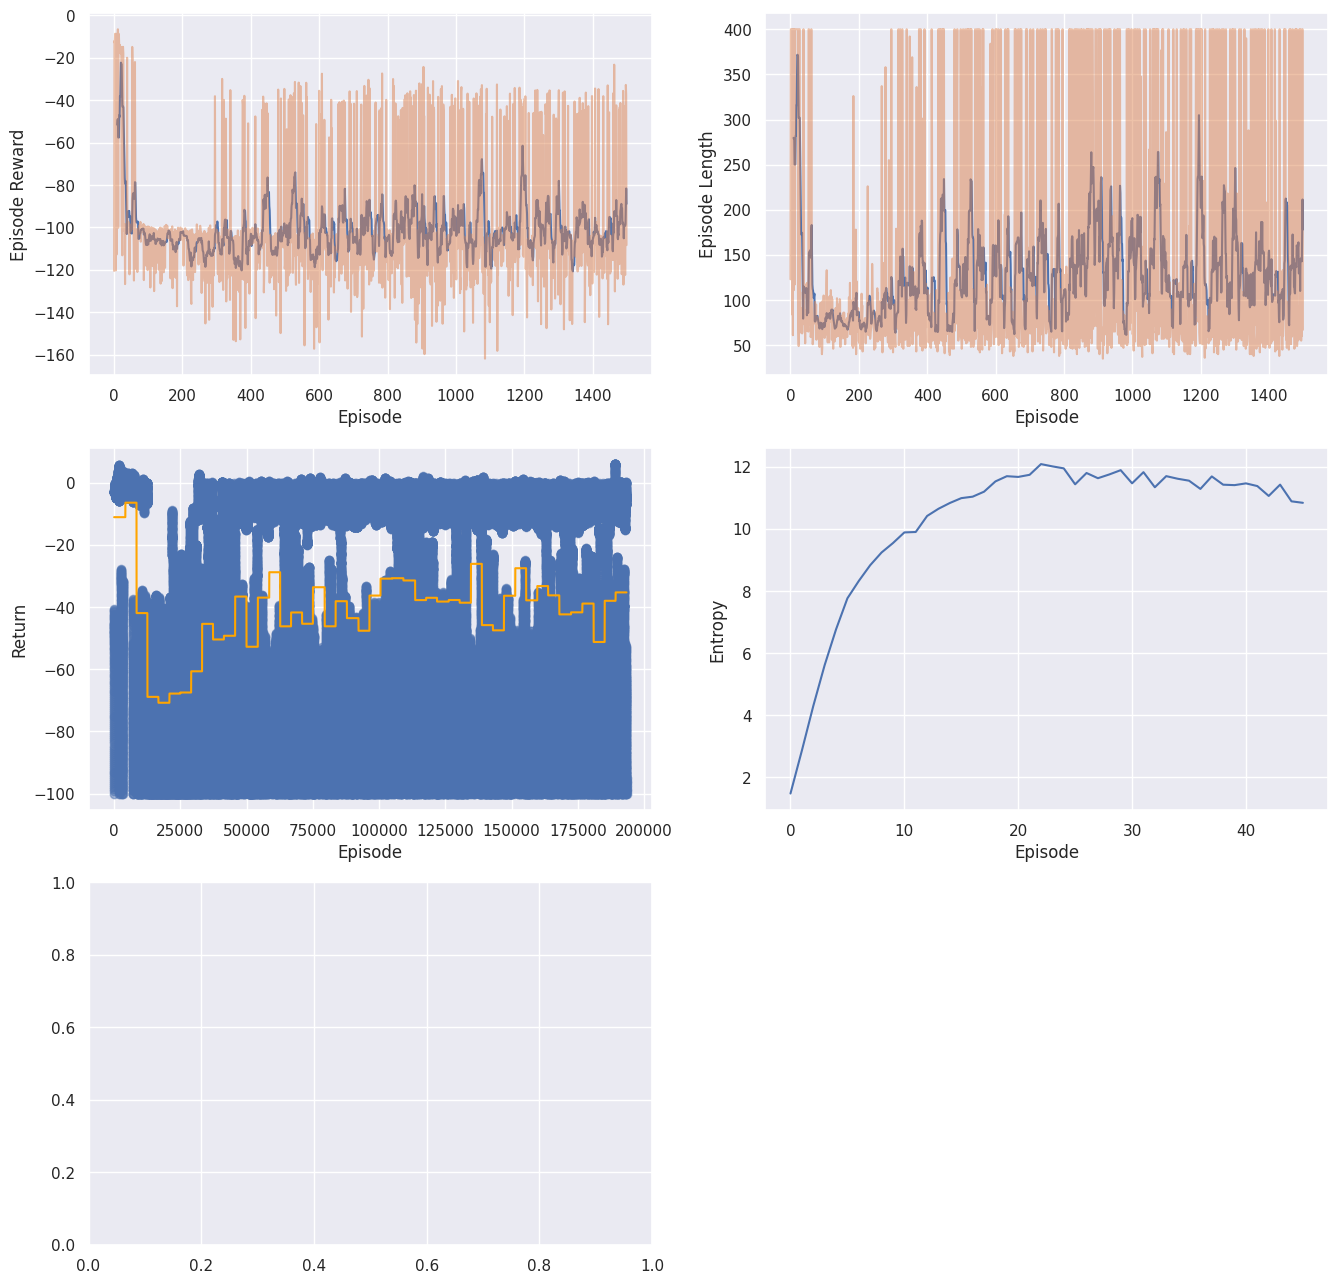

In [ ]:
plot_results(runner)

In [ ]:
agent.save_onnx_checkpoint()

## Visualize Agent

In [ ]:
# load model from checkpoint
agent.resume_checkpoint('ckpts/best-checkpoint.pth')

In [ ]:
# run agent in the envrionment
env, _, _ = create_env(logger)
agent.model.eval()
test_environment(env=env, agent=agent)
show_video(logger)

# Demo Evaluations

In [ ]:
agent.load_onnx_checkpoint('demo.onnx')

In [ ]:
# run agent in the envrionment
logger = Logger('logdir')
env, _, _ = create_env(logger)
agent.model.eval()
test_environment(env=env, agent=agent, n_steps=500)
show_video(logger)